In [1]:
import sys
sys.path.append("/glade/work/zhixing/python_scripts/SOM-SEASONAL/User-defined/")
from Synoptic_regimes import *
import wrf
import haversine as hs
import matplotlib.patches as patches

In [2]:
# #-- read the processed wrf output for accumulated snow/precipitation data (SNOWNC/ RAINNC)
rain, time, lons_wrf, lats_wrf = extract_wrf_rainnc_data(variable = 'precipitation') ## extract the hourly precip from WRF output
snow, time, lons_wrf, lats_wrf = extract_wrf_rainnc_data(variable = 'snow')


##----------------
NODE1_NUM = 2; NODE2_NUM = 2
# #-- running the self-organizing map, get the cluster results for each map
# w_x, w_y = SOM_processing(NODE1 = NODE1_NUM , NODE2 = NODE2_NUM , sigma = 1.1, l_r = 0.4, n_f = 'gaussian',r_s = 59, iterations=400, max_iter=1000)
w_x = np.load('/glade/work/zhixing/python_scripts/temp_w_x.npy')
w_y = np.load('/glade/work/zhixing/python_scripts/temp_w_y.npy')


# # #-- get the index for each node
dic_cluster, dic_time = Link_processing(NODE1=NODE1_NUM , NODE2 = NODE2_NUM, w_x = w_x, w_y = w_y, time = time)


Link data with cluster	 Finished...



In [3]:
#----------
#---------- the variables within the planetray boundary layer
pbl_wa0      = np.load("/glade/work/zhixing/Analysis_DATA/SNOWIE_seasonal_Data/Post-processing_data/pbl_wa0.npy")
pbl_wa1      = np.load("/glade/work/zhixing/Analysis_DATA/SNOWIE_seasonal_Data/Post-processing_data/pbl_wa1.npy")
pbl_wa2      = np.load("/glade/work/zhixing/Analysis_DATA/SNOWIE_seasonal_Data/Post-processing_data/pbl_wa2.npy")


#----------
#----------
pbl_tke0      = np.load("/glade/work/zhixing/Analysis_DATA/SNOWIE_seasonal_Data/Post-processing_data/pbl_tke0.npy")
pbl_tke1      = np.load("/glade/work/zhixing/Analysis_DATA/SNOWIE_seasonal_Data/Post-processing_data/pbl_tke1.npy")
pbl_tke2      = np.load("/glade/work/zhixing/Analysis_DATA/SNOWIE_seasonal_Data/Post-processing_data/pbl_tke2.npy")

#----------
#----------
pbl_rh0      = np.load("/glade/work/zhixing/Analysis_DATA/SNOWIE_seasonal_Data/Post-processing_data/pbl_rh0.npy")
pbl_rh1      = np.load("/glade/work/zhixing/Analysis_DATA/SNOWIE_seasonal_Data/Post-processing_data/pbl_rh1.npy")
pbl_rh2      = np.load("/glade/work/zhixing/Analysis_DATA/SNOWIE_seasonal_Data/Post-processing_data/pbl_rh2.npy")


#----------
#----------
pbl_wa      = np.vstack((pbl_wa0, pbl_wa1, pbl_wa2))
pbl_tke     = np.vstack((pbl_tke0, pbl_tke1, pbl_tke2))
pbl_rh      = np.vstack((pbl_rh0, pbl_rh1, pbl_rh2))


CPU times: user 5min 19s, sys: 2.58 s, total: 5min 21s
Wall time: 5min 22s


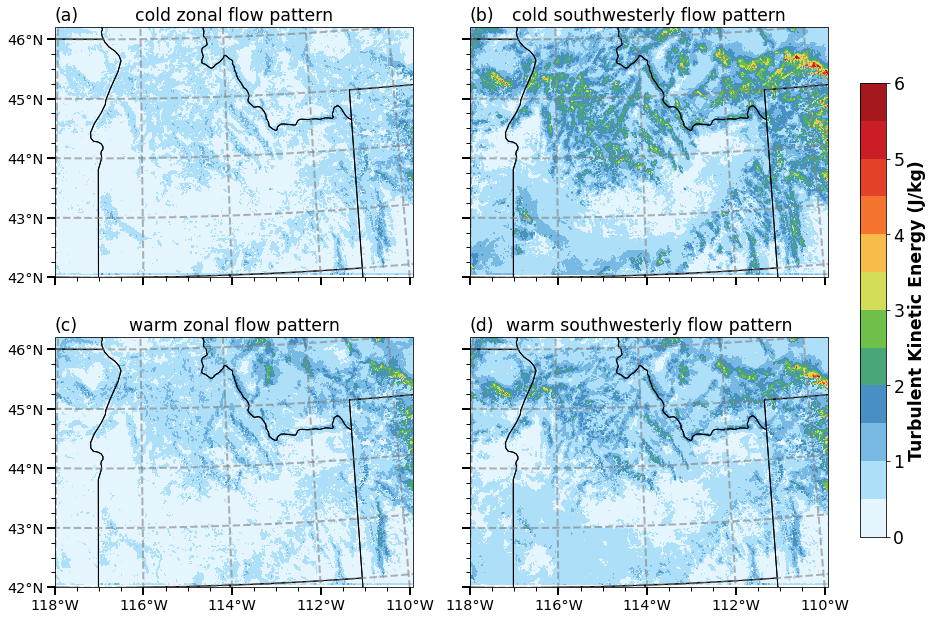

In [4]:
%%time
import cartopy.io.shapereader as shapereader

#====================Get the data====================
#============================================================
wrffile  = Dataset("/glade/work/zhixing/wrfout_d02_2017-01-01_00:00:00")
terrain  = getvar(wrffile, 'ter', timeidx=ALL_TIMES, method = "cat")
lon_wrf  = getvar(wrffile, "XLONG")
lat_wrf  = getvar(wrffile, "XLAT")
#====================Get map projection====================
#============================================================
mapcrs  = get_cartopy(terrain)
# mapcrs  = ccrs.LambertConformal(central_longitude=-115.5, central_latitude=44,standard_parallels=(40, 48))
datacrs = ccrs.PlateCarree()

#====================Plot====================
fig, axs = plt.subplots(2,2, figsize=(12,9), sharex=True, sharey=True, subplot_kw = {'projection':mapcrs})

for i in range(2):
    for j in range(2):
        ax = axs[i, j]
        index = dic_cluster[(i,j)]
        node_pbl_tke = np.nanmean(pbl_tke[index], axis=0)
        map_extent = [-118, -109.9, 42, 46]
        ax.set_extent(map_extent, crs = datacrs)
        ax.add_feature(cfeature.COASTLINE.with_scale('50m'))
        ax.add_feature(cfeature.STATES.with_scale('50m'))
        # ax.add_geometries([Idaho], ccrs.Geodetic(), edgecolor='red',
        #                   facecolor='none', linewidth=5)
        
        # ##--- ground precipitation distribution plot
        # lvls     = np.linspace(0,max_node_pbl_tke,15)
        lvls     = np.arange(0, 6.1, 0.5)  ## the levels of contour lines
        node_pbl_tke_map = ax.contourf(lon_wrf, lat_wrf, node_pbl_tke, cmap = cmaps.WhiteBlueGreenYellowRed, levels=lvls, transform = datacrs)

        # *must* call draw in order to get the axis boundary used to add ticks:
        fig.canvas.draw()
        xticks = list(np.arange(-118,-108,2)); yticks = list(np.arange(42,47,1))

        ax.gridlines(xlocs=xticks, ylocs=yticks,linestyle='--',lw=2,color='gray',alpha=0.6)# dimgrey
        # Label the end-points of the gridlines using the custom tick makers:
        ax.yaxis.set_major_formatter(LATITUDE_FORMATTER); ax.xaxis.set_major_formatter(LONGITUDE_FORMATTER) 
        ax.tick_params(axis='both',length=4,width=2,labelsize='x-large')
        """xx-small 5.79; x-small 6.94; small 8.33; medium 10.0; large 12.0; x-large 14.4; xx-large 17.28; larger 12.0; smaller 8.33"""

        # https://stackoverflow.com/questions/30030328/correct-placement-of-colorbar-relative-to-geo-axes-cartopy
        lambert_yticks(ax, yticks); lambert_xticks(ax, xticks)
        ax.tick_params(axis='both',  length=8, width=2, labelsize='x-large')
        ax.tick_params(which='minor',length=4, width=1,labelsize='x-large')
        ax.xaxis.set_minor_locator(ticker.AutoMinorLocator())
        ax.yaxis.set_minor_locator(ticker.AutoMinorLocator())

axs[0,0].set_title("(a)", loc='left', fontsize='xx-large'); axs[0,1].set_title("(b)", loc='left', fontsize='xx-large')
axs[1,0].set_title("(c)", loc='left', fontsize='xx-large'); axs[1,1].set_title("(d)", loc='left', fontsize='xx-large')

axs[0,0].set_title('cold zonal flow pattern', fontsize='xx-large'); axs[0,1].set_title('cold southwesterly flow pattern', fontsize='xx-large');
axs[1,0].set_title('warm zonal flow pattern', fontsize='xx-large'); axs[1,1].set_title('warm southwesterly flow pattern', fontsize='xx-large')

cax  = plt.axes([1, 0.15, 0.03, 0.7])
cbar = fig.colorbar(node_pbl_tke_map, cax = cax)
cbar.ax.tick_params(labelsize='xx-large') 
cbar.set_label(label='Turbulent Kinetic Energy (J/kg)', weight='bold', fontsize='xx-large')
fig.tight_layout()

CPU times: user 9min 12s, sys: 10.1 s, total: 9min 22s
Wall time: 9min 22s


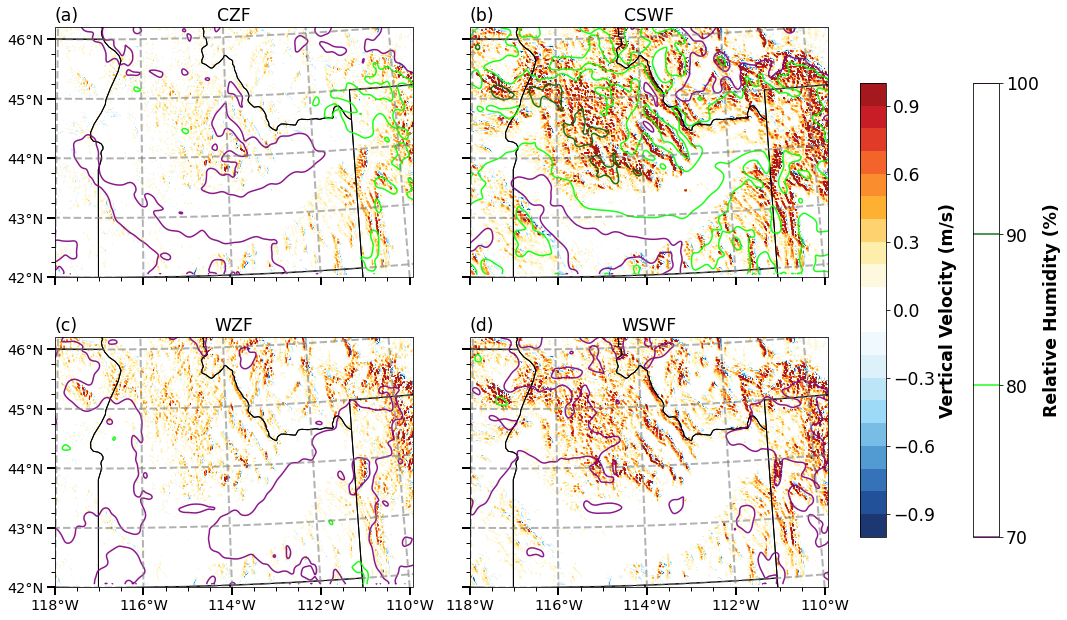

In [5]:
%%time
import cartopy.io.shapereader as shapereader

#====================Get the data====================
#============================================================
wrffile  = Dataset("/glade/work/zhixing/wrfout_d02_2017-01-01_00:00:00")
terrain  = getvar(wrffile, 'ter', timeidx=ALL_TIMES, method = "cat")
lon_wrf  = getvar(wrffile, "XLONG")
lat_wrf  = getvar(wrffile, "XLAT")
#====================Get map projection====================
#============================================================
mapcrs  = get_cartopy(terrain)
# mapcrs  = ccrs.LambertConformal(central_longitude=-115.5, central_latitude=44,standard_parallels=(40, 48))
datacrs = ccrs.PlateCarree()

#====================Plot====================
fig, axs = plt.subplots(2,2, figsize=(12,9), sharex=True, sharey=True, subplot_kw = {'projection':mapcrs})

for i in range(2):
    for j in range(2):
        ax = axs[i, j]
        index = dic_cluster[(i,j)]
        node_pbl_wa    = np.nanmean(pbl_wa[index], axis=0)
        node_pbl_rh    = np.nanmean(pbl_rh[index], axis=0)
        map_extent = [-118, -109.9, 42, 46]
        ax.set_extent(map_extent, crs = datacrs)
        ax.add_feature(cfeature.COASTLINE.with_scale('50m'))
        ax.add_feature(cfeature.STATES.with_scale('50m'))
        # ax.add_geometries([Idaho], ccrs.Geodetic(), edgecolor='red',
        #                   facecolor='none', linewidth=5)
        
        # ##--- ground precipitation distribution plot
        # lvls     = np.linspace(0,max_node_pbl_wa,15)
        lvls     = np.arange(-1, 1.01, 0.1)
        node_pbl_wa_map = ax.contourf(lon_wrf, lat_wrf, node_pbl_wa, cmap = cmaps.BlueWhiteOrangeRed, levels=lvls, transform = datacrs)
        
        for k in range(15):
            #*** smooth the raw data and then overplap
            node_pbl_rh     = wrf.smooth2d(node_pbl_rh, passes = 10)  ## try to smooth data and then plot
            
        lvls     = [70,80,90,100]
        node_pbl_rh_map = ax.contour(lon_wrf, lat_wrf, node_pbl_rh, levels=lvls, colors = ['purple','lime','darkgreen'], transform = datacrs, alpha=0.9)

        # *must* call draw in order to get the axis boundary used to add ticks:
        fig.canvas.draw()
        xticks = list(np.arange(-118,-108,2)); yticks = list(np.arange(42,47,1))

        ax.gridlines(xlocs=xticks, ylocs=yticks,linestyle='--',lw=2,color='gray',alpha=0.6)# dimgrey
        # Label the end-points of the gridlines using the custom tick makers:
        ax.yaxis.set_major_formatter(LATITUDE_FORMATTER); ax.xaxis.set_major_formatter(LONGITUDE_FORMATTER) 
        """xx-small 5.79; x-small 6.94; small 8.33; medium 10.0; large 12.0; x-large 14.4; xx-large 17.28; larger 12.0; smaller 8.33"""

        # https://stackoverflow.com/questions/30030328/correct-placement-of-colorbar-relative-to-geo-axes-cartopy
        lambert_yticks(ax, yticks); lambert_xticks(ax, xticks)
        ax.tick_params(axis='both',  length=8, width=2, labelsize='x-large')
        ax.tick_params(which='minor',length=4, width=1,labelsize='x-large')
        ax.xaxis.set_minor_locator(ticker.AutoMinorLocator())
        ax.yaxis.set_minor_locator(ticker.AutoMinorLocator())

axs[0,0].set_title("(a)", loc='left', fontsize='xx-large'); axs[0,1].set_title("(b)", loc='left', fontsize='xx-large')
axs[1,0].set_title("(c)", loc='left', fontsize='xx-large'); axs[1,1].set_title("(d)", loc='left', fontsize='xx-large')

axs[0,0].set_title('CZF', fontsize='xx-large'); axs[0,1].set_title('CSWF', fontsize='xx-large');
axs[1,0].set_title('WZF', fontsize='xx-large'); axs[1,1].set_title('WSWF', fontsize='xx-large')

##-----------------
cax  = plt.axes([1, 0.15, 0.03, 0.7])
cbar = fig.colorbar(node_pbl_wa_map, cax = cax)
cbar.ax.tick_params(labelsize='xx-large') 
cbar.set_label(label='Vertical Velocity (m/s)', weight='bold', fontsize='xx-large')

##-----------------
cax  = plt.axes([1.13, 0.15, 0.03, 0.7])
cbar = fig.colorbar(node_pbl_rh_map, cax = cax)
cbar.ax.tick_params(labelsize='xx-large') 
cbar.set_label(label = 'Relative Humidity (%)', weight='bold', fontsize='xx-large')
fig.tight_layout()